In [ ]:
from numpy.random import seed
seed(7567)
from tensorflow import set_random_seed
set_random_seed(7567)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from datagen import *
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

NUM_ROWS = 20000

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans Serif"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [4]:
#statistics collection
num_runs=1
num_rowss=[10000]
batch_size=32
epochss=[25]
verbose=1

TARS = tf.keras.models.Sequential()
TARS.add(tf.keras.layers.Dense(input_dim = 29 ,units = 50, activation='relu'))
TARS.add(tf.keras.layers.Dense(units=30, activation='relu'))
TARS.add(tf.keras.layers.Dense(units=50, activation='relu'))
TARS.add(tf.keras.layers.Dense(units=1, activation='linear'))
TARS.compile(optimizer="adam", loss="mean_squared_error", metrics=['mse'])

matrix=[]
for epochs in epochss:
    epoch_row=[]
    for num_rows in num_rowss:
        loss_array=[]
        for i in range(num_runs):
            dframe = pd.DataFrame()
            dframe = datagen(num_rows)
            x = dframe.iloc[:, 1:-1].values
            y = dframe.iloc[:, -1].values
            le = LabelEncoder()
            x[:, 0] = le.fit_transform(x[:,0])
            ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [2])], remainder='passthrough')
            x = np.array(ct.fit_transform(x))
            ct2 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [7])], remainder='passthrough')
            x = np.array(ct2.fit_transform(x))
            ct3 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [18])], remainder='passthrough')
            x = np.array(ct3.fit_transform(x))
            scalarX, scalarY = MinMaxScaler(), MinMaxScaler()
            scalarX.fit(x)
            scalarY.fit(y.reshape(num_rows,1))
            x = scalarX.transform(x)
            y = scalarY.transform(y.reshape(num_rows,1))
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
            for ix, layer in enumerate(TARS.layers):
                if hasattr(TARS.layers[ix], 'kernel_initializer') and hasattr(TARS.layers[ix], 'bias_initializer'):
                    weight_initializer=TARS.layers[ix].kernel_initializer
                    bias_initializer=TARS.layers[ix].bias_initializer
                    
                    old_weights, old_biases = TARS.layers[ix].get_weights()
                    
                    TARS.layers[ix].set_weights([weight_initializer(shape=old_weights.shape), bias_initializer(shape=len(old_biases))])
            TARS.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose)
            error=TARS.evaluate(x_test, y_test, verbose=0)[0]
            #print(f"Run {i} finished, mean_squared_error: {error}")
            y_pred = TARS.predict(x_test)
            y_test = scalarY.inverse_transform(y_test)
            y_pred = scalarY.inverse_transform(y_pred)
            explained_variance = 1 - np.var(y_test - y_pred)/np.var(y_test)
            mse = (sum((y_test-y_pred)**2)/len(y_pred))[0]
            loss_array.append([error, explained_variance, mse])
        print(f"Epoch number: {epochs}, num_rows: {num_rows}, model loss: {sum([a[0] for a in loss_array])/len(loss_array)}, explained variance: {sum([a[1] for a in loss_array])/len(loss_array)*100}%, mse: {sum([a[2] for a in loss_array])/len(loss_array)}")
        epoch_row.append(loss_array)
    matrix.append(epoch_row)
print(matrix)

Epoch 1/25
250/250 [==============================] - 1s 2ms/step - loss: 0.0349 - mse: 0.0349
Epoch 2/25
250/250 [==============================] - 0s 2ms/step - loss: 0.0088 - mse: 0.0088
Epoch 3/25
250/250 [==============================] - 0s 2ms/step - loss: 0.0056 - mse: 0.0056
Epoch 4/25
250/250 [==============================] - 0s 2ms/step - loss: 0.0048 - mse: 0.0048
Epoch 5/25
250/250 [==============================] - 0s 2ms/step - loss: 0.0046 - mse: 0.0046
Epoch 6/25
250/250 [==============================] - 0s 2ms/step - loss: 0.0043 - mse: 0.0043
Epoch 7/25
250/250 [==============================] - 0s 2ms/step - loss: 0.0042 - mse: 0.0042
Epoch 8/25
250/250 [==============================] - 0s 2ms/step - loss: 0.0042 - mse: 0.0042
Epoch 9/25
250/250 [==============================] - 0s 2ms/step - loss: 0.0040 - mse: 0.0040
Epoch 10/25
250/250 [==============================] - 0s 2ms/step - loss: 0.0040 - mse: 0.0040
Epoch 11/25
250/250 [============================

In [32]:
pd.get_dummies(dframe).iloc[0,1:]

age                                          6.000000
class_size                                  37.000000
gpadifference                               -1.604922
gender_Female                                0.000000
gender_Male                                  1.000000
teacher_cred_Associate's                     1.000000
teacher_cred_Bachelor's                      0.000000
teacher_cred_Master's                        0.000000
teacher_cred_PhD                             0.000000
disability_ADHD                              0.000000
disability_Auditory Disability               0.000000
disability_Autism                            0.000000
disability_Developmentally Delayed           1.000000
disability_Down Syndrome                     0.000000
disability_Dyslexia                          0.000000
disability_Low Emotional Intelligence        0.000000
disability_Mathematics Disability            0.000000
disability_Reading Disability                0.000000
disability_Speaking Disabili

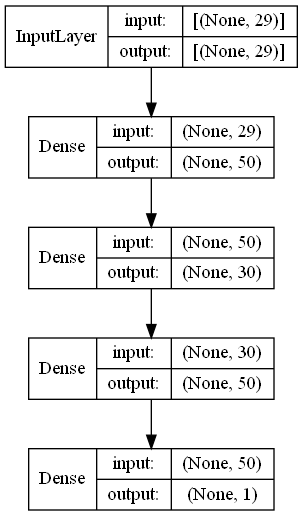

In [5]:
tf.keras.utils.plot_model(
    TARS,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [5]:
from ann_visualizer.visualize import ann_viz

ann_viz(TARS, title="Keras Model Diagram")

ValueError: ANN Visualizer: Layer not supported for visualizing

In [43]:
dframe = pd.DataFrame()
dframe = datagen(NUM_ROWS)

In [44]:
dframe

,studentIDs,gender,age,teacher_cred,class_size,disability,accomadation,gpadifference
0,27183,Male,16,Associate's,31,Reading Disability,Use of Calculator on Tests,0.344062
1,21516,Female,13,Master's,32,Mathematics Disability,Materials in Braille,-0.570967
2,33675,Male,18,Bachelor's,29,Auditory Disability,Isolated Workstation,-0.280337
3,41888,Male,14,Master's,35,Developmentally Delayed,Tutoring Sessions,-0.131622
4,49633,Male,13,Master's,34,Developmentally Delayed,Use of Toy in Class,-0.138977
...,...,...,...,...,...,...,...,...
19995,45198,Female,14,Master's,44,ADHD,Bigger Print Materials,0.805756
19996,19256,Female,9,PhD,25,Low Emotional Intelligence,Book Buddy,1.191627
19997,49201,Female,8,Master's,32,Down Syndrome,Isolated Workstation,1.939959
19998,29042,Male,15,PhD,28,Auditory Disability,Tutoring Sessions,0.215956


In [45]:
x = dframe.iloc[:, 1:-1].values
y = dframe.iloc[:, -1].values

In [46]:
le = LabelEncoder()
x[:, 0] = le.fit_transform(x[:,0])
print(x)

[[1 16 "Associate's" 31 'Reading Disability' 'Use of Calculator on Tests']
 [0 13 "Master's" 32 'Mathematics Disability' 'Materials in Braille']
 [1 18 "Bachelor's" 29 'Auditory Disability' 'Isolated Workstation']
 ...
 [0 8 "Master's" 32 'Down Syndrome' 'Isolated Workstation']
 [1 15 'PhD' 28 'Auditory Disability' 'Tutoring Sessions']
 [1 6 "Associate's" 28 'Auditory Disability'
  'Special Education Classroom']]


In [47]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [2])], remainder='passthrough')
x = np.array(ct.fit_transform(x))
ct2 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [7])], remainder='passthrough')
x = np.array(ct2.fit_transform(x))
ct3 = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [18])], remainder='passthrough')
x = np.array(ct3.fit_transform(x))

In [48]:
scalarX, scalarY = MinMaxScaler(), MinMaxScaler()
scalarX.fit(x)
scalarY.fit(y.reshape(NUM_ROWS,1))
x = scalarX.transform(x)
y = scalarY.transform(y.reshape(NUM_ROWS,1))

In [49]:
# Coulums 0-3 are highest degree
# colums 4 is gender
# colum 5 is normalized age
# colum 6 is normalized class sized

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=7687)

In [51]:
# container for adding layers to nuerual net
TARS = tf.keras.models.Sequential()

In [11]:
TARS.add(tf.keras.layers.Dense(input_dim = 29 ,units = 50, activation='relu'))
TARS.add(tf.keras.layers.Dense(units=30, activation='relu'))
TARS.add(tf.keras.layers.Dense(units=50, activation='relu'))
TARS.add(tf.keras.layers.Dense(units=1, activation='linear'))

In [12]:
TARS.compile(optimizer="adam", loss="mean_squared_error", metrics=['mse'])

In [13]:

TARS.fit(x_train, y_train, batch_size=32, epochs=100)

Epoch 1/100
500/500 [==============================] - 2s 2ms/step - loss: 0.0199 - mse: 0.0199
Epoch 2/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0053 - mse: 0.0053
Epoch 3/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0046 - mse: 0.0046
Epoch 4/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0045 - mse: 0.0045
Epoch 5/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0044 - mse: 0.0044
Epoch 6/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0043 - mse: 0.0043
Epoch 7/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0043 - mse: 0.0043
Epoch 8/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0042 - mse: 0.0042
Epoch 9/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0041 - mse: 0.0041
Epoch 10/100
500/500 [==============================] - 1s 2ms/step - loss: 0.0041 - mse: 0.0041
Epoch 11/100
500/500 [=================



*   List item
*   List item



In [14]:
TARS.save("weights.h5")

In [15]:
TARS.evaluate(x_test, y_test)

125/125 [==============================] - 0s 968us/step - loss: 0.0044 - mse: 0.0044


[0.004357358906418085, 0.004357358906418085]

In [19]:
TARS.predict(x_test)

array([[0.38861433],
       [0.8379196 ],
       [0.61360025],
       ...,
       [0.5294008 ],
       [0.43504548],
       [0.51618   ]], dtype=float32)

In [18]:
x_test[0:1]

array([[0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 1.        , 0.66666667, 0.48717949]])

In [38]:
# give me a student and lets try some accomedation
# take in a normal row input
# changing accomedation
# class size 
# teacher_cre

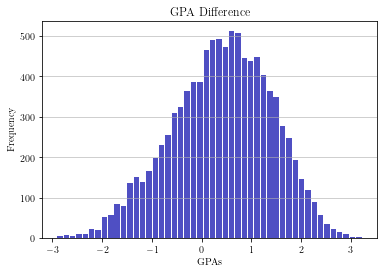

In [11]:
n, bins, patches = plt.hist(x=dframe['gpadifference'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('GPAs')
plt.ylabel('Frequency')
plt.title('GPA Difference')
plt.savefig("gpa.svg", format="svg")

array([[<AxesSubplot:xlabel='gender', ylabel='gender'>,
        <AxesSubplot:xlabel='age', ylabel='gender'>,
        <AxesSubplot:xlabel='teacher_cred', ylabel='gender'>,
        <AxesSubplot:xlabel='class_size', ylabel='gender'>,
        <AxesSubplot:xlabel='disability', ylabel='gender'>,
        <AxesSubplot:xlabel='accomadation', ylabel='gender'>,
        <AxesSubplot:xlabel='gpadifference', ylabel='gender'>],
       [<AxesSubplot:xlabel='gender', ylabel='age'>,
        <AxesSubplot:xlabel='age', ylabel='age'>,
        <AxesSubplot:xlabel='teacher_cred', ylabel='age'>,
        <AxesSubplot:xlabel='class_size', ylabel='age'>,
        <AxesSubplot:xlabel='disability', ylabel='age'>,
        <AxesSubplot:xlabel='accomadation', ylabel='age'>,
        <AxesSubplot:xlabel='gpadifference', ylabel='age'>],
       [<AxesSubplot:xlabel='gender', ylabel='teacher_cred'>,
        <AxesSubplot:xlabel='age', ylabel='teacher_cred'>,
        <AxesSubplot:xlabel='teacher_cred', ylabel='teacher_cred'>

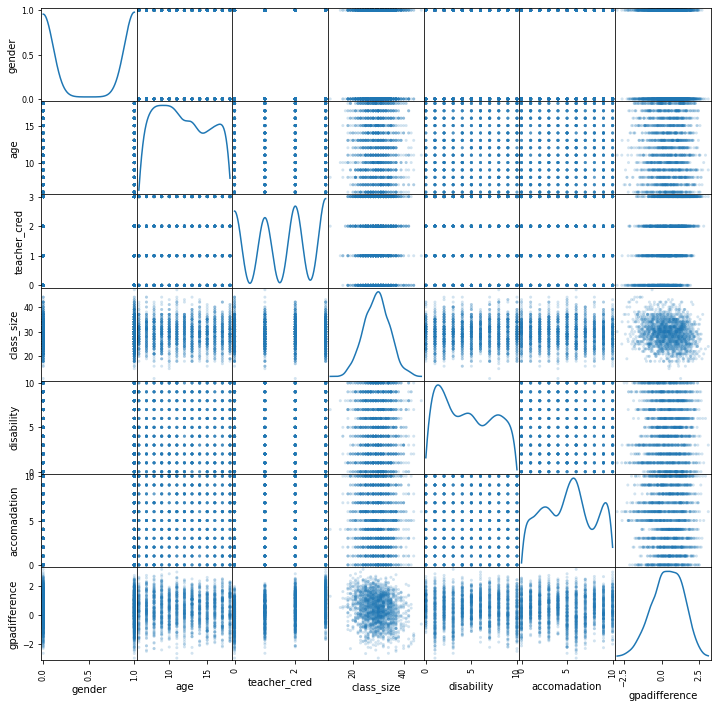

In [38]:
#multi-graph display of all data
from pandas.plotting import scatter_matrix
le = LabelEncoder()
le_dframe = dframe
le_dframe[['gender', 'teacher_cred', 'disability', 'accomadation']] = le_dframe[['gender', 'teacher_cred', 'disability', 'accomadation']].apply(le.fit_transform)
scatter_matrix(le_dframe.iloc[:1999, 1:], alpha=0.2, figsize=(12, 12), diagonal='kde')

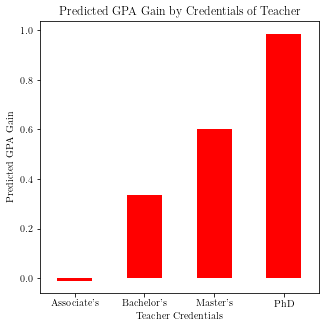

In [13]:
dframe.query("disability == 'Autism'").groupby(['teacher_cred']).mean()['gpadifference'].plot.bar(data, figsize=(5,5), color = 'red')
plt.xlabel('Teacher Credentials')
plt.ylabel('Predicted GPA Gain')
plt.xticks(rotation=0)
plt.title('Predicted GPA Gain by Credentials of Teacher')
plt.savefig("pattern.svg", format="svg", dpi=300, bbox_inches='tight')

In [ ]:
TARS.predict(np.array([[0,1,0,0,1,0.5,0.5]]))

# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 5, 10, 50],
              'gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid, verbose=3)
Mohan to Everyone (12:01 PM)
grid.fit(X_train, y_train)
print(grid.best_params_)

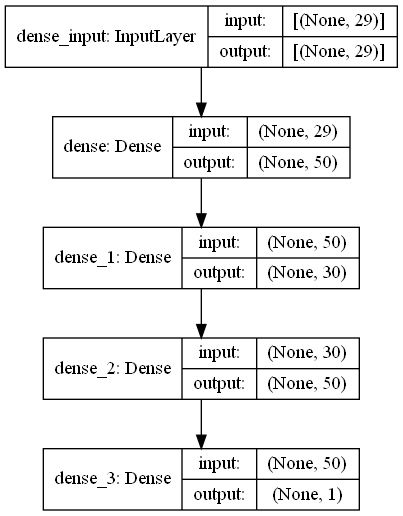

In [2]:
TARS = tf.keras.models.Sequential()
TARS.add(tf.keras.layers.Dense(input_dim = 29 ,units = 50, activation='relu'))
TARS.add(tf.keras.layers.Dense(units=30, activation='relu'))
TARS.add(tf.keras.layers.Dense(units=50, activation='relu'))
TARS.add(tf.keras.layers.Dense(units=1, activation='linear'))
TARS.compile(optimizer="adam", loss="mean_squared_error", metrics=['mse', 'accuracy'])
TARS.load_weights('weights.h5')
from keras.utils.vis_utils import plot_model
plot_model(TARS, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [65]:
def predict(sample_student):
    maxdif = -4
    bestaccom = ""
    accomodation_list = ["Materials in Braille", "Text to Speech Devices", "Breakout Corner", "Use of Toy in Class", "Bigger Print Materials", "Isolated Workstation", "Tutoring Sessions", "Book Buddy", "Use of Calculator on Tests", "AAC Devices", "Special Education Classroom"]
    if sample_student[0][-1] in accomodation_list:
        accomodation_list = [sample_student[0][-1]]
    gpadiffs = []
    for i in accomodation_list:
        temparray= [[]] 
        temparray[0] = np.append(sample_student, i)
        temparray = np.array(temparray)
        temparray[:, 0] = le.transform(temparray[:,0])
        temparray = np.array(ct.transform(temparray))
        temparray = np.array(ct2.transform(temparray))
        temparray = np.array(ct3.transform(temparray))
        temparray = scalarX.transform(temparray)
        gpadiffs.append(scalarY.inverse_transform(TARS.predict(np.array(temparray)))[0][0])
        if (scalarY.inverse_transform(TARS.predict(np.array(temparray)))[0][0] > maxdif):
            maxdif = scalarY.inverse_transform(TARS.predict(np.array(temparray)))
            bestaccom = i
    
    if len(gpadiffs) > 1:
        fig = plt.figure(figsize=(6,4))
        ax = fig.add_axes([0,0,1,1])
        plt.xticks(rotation=0, fontsize=6)
        ax.bar(accomodation_list, gpadiffs)
        plt.xlabel('Accomodations')
        plt.ylabel('Predicted GPA Difference')
        plt.title('Predicted GPA Gain by Accomodation Given')
        labels = ax.get_xticklabels()
        for i, label in enumerate(labels):
            label.set_y(label.get_position()[1] - (i % 2) * 0.035)
        plt.savefig("predict.svg", format="svg", dpi=300, bbox_inches='tight')
        print(f"{bestaccom} is the predicted best accomodation.")
    else:
        print(f"Predicted GPA Difference for this student is: {gpadiffs[0]}.")

Isolated Workstation is the predicted best accomodation.


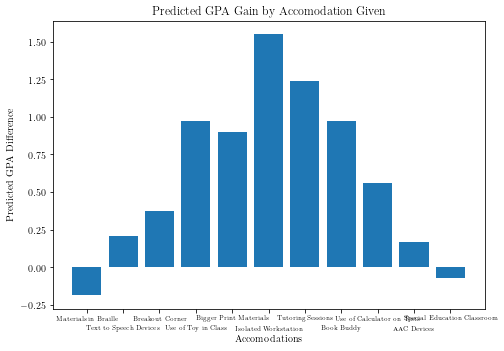

In [66]:
#predicting which accommodation is most effective given a student
#input: gender, age, teacher_cred, class size, disability
predict(np.array([["Female", "15", "Bachelor's", "25", "ADHD"]]))

In [ ]:

#TARS = tf.keras.models.load_model('weights.h5')


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [1, 5, 10, 50], 'gamma': [0.0001, 0.0005, 0.001, 0.005]} 
grid = GridSearchCV(TARS, param_grid, verbose=3)

In [ ]:
# TARS.layers[1].get_weights()

GridSearch
Figure out which columns are the most impactful
transform outputs back
fix environment

In [ ]:
# from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
# import eli5
# from eli5.sklearn import PermutationImportance

In [ ]:
# my_model = KerasRegressor(build, epochs=100, batch_size=200)    
# my_model.fit(x,y)

In [ ]:
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score

# kfold = KFold(n_splits=10)
# results = cross_val_score(my_model, x, y, cv=kfold)


In [ ]:
# TARS

In [ ]:
# import shap

In [ ]:
# shap.initjs()

In [ ]:
# explainer = shap.TreeExplainer(TARS)
# shap_values = explainer.shap_values(x)

In [ ]:
# # permutation feature importance with knn for classification
# from sklearn.datasets import make_classification
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.inspection import permutation_importance
# from matplotlib import pyplot
# # define dataset
# # define the model
# # fit the model
# # perform permutation importance
# results = permutation_importance(TARS, x, y, scoring='accuracy')
# # get importance
# importance = results.importances_mean
# # summarize feature importance
# for i,v in enumerate(importance):
# 	print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.show()

